In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [107]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_aug)
cifar10_dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_no_aug)

train_set = Subset(cifar10_dataset_train, range(0, 2000))
val_set = Subset(cifar10_dataset_test, range(0, 1000))

Files already downloaded and verified
Files already downloaded and verified


In [108]:
# Criando DataLoaders para os subsets
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

In [109]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 16 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN()

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [111]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

100%|██████████| 32/32 [00:01<00:00, 17.17it/s]


Epoch 1, Train Loss: 2.253, Train Accuracy: 13.90%
Epoch 1, Val Loss: 2.102, Val Accuracy: 22.00%


100%|██████████| 32/32 [00:01<00:00, 17.07it/s]


Epoch 2, Train Loss: 2.096, Train Accuracy: 20.80%
Epoch 2, Val Loss: 2.040, Val Accuracy: 24.00%


100%|██████████| 32/32 [00:01<00:00, 17.36it/s]


Epoch 3, Train Loss: 2.033, Train Accuracy: 24.30%
Epoch 3, Val Loss: 1.957, Val Accuracy: 29.00%


100%|██████████| 32/32 [00:01<00:00, 16.77it/s]


Epoch 4, Train Loss: 1.969, Train Accuracy: 26.50%
Epoch 4, Val Loss: 1.917, Val Accuracy: 30.70%


100%|██████████| 32/32 [00:01<00:00, 17.23it/s]


Epoch 5, Train Loss: 1.919, Train Accuracy: 27.65%
Epoch 5, Val Loss: 1.851, Val Accuracy: 33.00%


100%|██████████| 32/32 [00:01<00:00, 16.69it/s]


Epoch 6, Train Loss: 1.910, Train Accuracy: 28.70%
Epoch 6, Val Loss: 1.820, Val Accuracy: 34.20%


100%|██████████| 32/32 [00:01<00:00, 17.22it/s]


Epoch 7, Train Loss: 1.845, Train Accuracy: 31.50%
Epoch 7, Val Loss: 1.798, Val Accuracy: 33.70%


100%|██████████| 32/32 [00:01<00:00, 17.00it/s]


Epoch 8, Train Loss: 1.831, Train Accuracy: 31.90%
Epoch 8, Val Loss: 1.743, Val Accuracy: 36.70%


100%|██████████| 32/32 [00:01<00:00, 16.57it/s]


Epoch 9, Train Loss: 1.794, Train Accuracy: 32.90%
Epoch 9, Val Loss: 1.703, Val Accuracy: 37.40%


100%|██████████| 32/32 [00:01<00:00, 16.62it/s]


Epoch 10, Train Loss: 1.749, Train Accuracy: 34.30%
Epoch 10, Val Loss: 1.712, Val Accuracy: 38.10%
Treinamento concluído


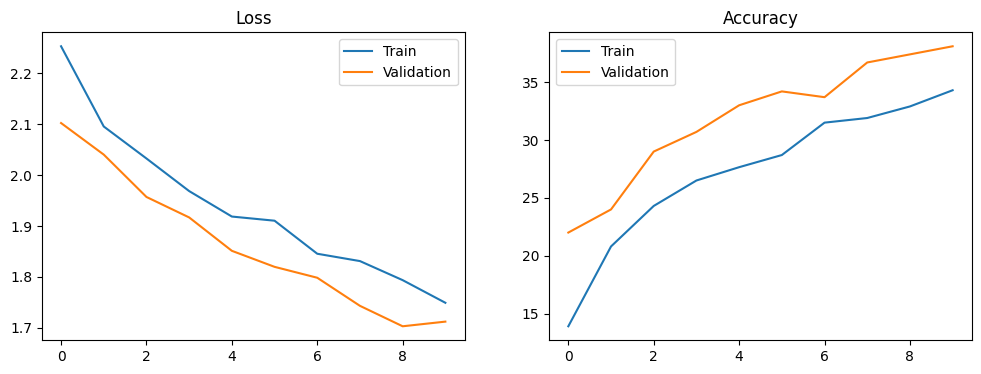

In [112]:
plot_history(history)